# Data Augmentation for CV Aim Assist

This notebook generates synthetic training data by placing game characters from `character_frames_no_bg` onto scene images from a `scenes` directory. 

## Features:
- Randomly selects scene images and number of characters (1-4)
- Places characters with realistic sizing based on simulated distance from player
- Adjusts character lighting to match surrounding environment using computer vision
- Saves augmented images with proper annotations

## Configuration:
Adjust `NUM_ITERATIONS` to control how many augmented images to generate.

In [62]:
import os
import random
import numpy as np
import cv2
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
from pathlib import Path
import json
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Configuration
SCENES_DIR = "scenes"
CHARACTERS_DIR = "character_frames_no_bg"
OUTPUT_DIR = "augmented_data"
ANNOTATIONS_DIR = os.path.join(OUTPUT_DIR, "annotations")
YOLO_LABELS_DIR = os.path.join(OUTPUT_DIR, "labels")  # YOLO format labels
NUM_ITERATIONS = 100  # Change this to control how many images to generate
ENABLE_LIGHTING_ADJUSTMENT = True  # Set to False to disable lighting adjustment
LIGHTING_STRENGTH = 0.3  # How strong the lighting adjustment should be (0.0 = none, 1.0 = full)

# Create output directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(ANNOTATIONS_DIR, exist_ok=True)
os.makedirs(YOLO_LABELS_DIR, exist_ok=True)

print(f"Configuration loaded:")
print(f"- Scenes directory: {SCENES_DIR}")
print(f"- Characters directory: {CHARACTERS_DIR}")
print(f"- Output directory: {OUTPUT_DIR}")
print(f"- YOLO labels directory: {YOLO_LABELS_DIR}")
print(f"- Number of iterations: {NUM_ITERATIONS}")
print(f"- Lighting adjustment: {'Enabled' if ENABLE_LIGHTING_ADJUSTMENT else 'Disabled'}")
if ENABLE_LIGHTING_ADJUSTMENT:
    print(f"- Lighting strength: {LIGHTING_STRENGTH}")

Configuration loaded:
- Scenes directory: scenes
- Characters directory: character_frames_no_bg
- Output directory: augmented_data
- YOLO labels directory: augmented_data/labels
- Number of iterations: 100
- Lighting adjustment: Enabled
- Lighting strength: 0.3


In [63]:
def load_image_paths(directory):
    """Load all image paths from a directory"""
    extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    paths = []
    for ext in extensions:
        paths.extend(Path(directory).glob(f"*{ext}"))
        paths.extend(Path(directory).glob(f"*{ext.upper()}"))
    return [str(p) for p in paths]

def load_character_poses():
    """Load character poses organized by character"""
    character_poses = {}
    if not os.path.exists(CHARACTERS_DIR):
        print(f"Character directory {CHARACTERS_DIR} not found!")
        return character_poses
    
    for item in os.listdir(CHARACTERS_DIR):
        item_path = os.path.join(CHARACTERS_DIR, item)
        if os.path.isdir(item_path):
            # Character folder
            poses = load_image_paths(item_path)
            if poses:
                character_poses[item] = poses
        elif item.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Single character image
            char_name = os.path.splitext(item)[0]
            if char_name not in character_poses:
                character_poses[char_name] = []
            character_poses[char_name].append(item_path)
    
    return character_poses

# Load scene images and character poses
scene_paths = load_image_paths(SCENES_DIR)
character_poses = load_character_poses()

# Create single class mapping for YOLO - all characters are "enemy"
character_classes = {}
class_names = ["enemy"]  # Single class for all characters
for char_name in character_poses.keys():
    character_classes[char_name] = 0  # All characters get class ID 0

print(f"Found {len(scene_paths)} scene images")
print(f"Found {len(character_poses)} characters with poses:")
for char, poses in list(character_poses.items())[:5]:  # Show first 5
    print(f"  - {char}: {len(poses)} poses (class_id: enemy)")
if len(character_poses) > 5:
    print(f"  ... and {len(character_poses) - 5} more characters")
print(f"All characters will be labeled as class 'enemy' (class_id: 0)")

# Save class names file for YOLO
class_names_path = os.path.join(OUTPUT_DIR, "classes.txt")
with open(class_names_path, 'w') as f:
    f.write("enemy\n")
print(f"Saved class names to: {class_names_path}")

Found 3 scene images
Found 546 characters with poses:
  - 10634: 8 poses (class_id: enemy)
  - 869: 8 poses (class_id: enemy)
  - 16197: 8 poses (class_id: enemy)
  - 338: 8 poses (class_id: enemy)
  - 738: 8 poses (class_id: enemy)
  ... and 541 more characters
All characters will be labeled as class 'enemy' (class_id: 0)
Saved class names to: augmented_data/classes.txt


In [64]:
def adjust_lighting(character_img, background_crop):
    """
    Adjust character lighting to match background using computer vision techniques
    Preserves alpha channel for transparent PNGs
    """
    # Check if lighting adjustment is disabled
    if not ENABLE_LIGHTING_ADJUSTMENT:
        return character_img
        
    try:
        # Preserve alpha channel if present
        has_alpha = character_img.shape[2] == 4
        if has_alpha:
            alpha_channel = character_img[:, :, 3]
            char_rgb = character_img[:, :, :3]
        else:
            char_rgb = character_img
        
        # Convert to LAB color space for better lighting adjustment
        char_lab = cv2.cvtColor(char_rgb, cv2.COLOR_RGB2LAB)
        bg_lab = cv2.cvtColor(background_crop, cv2.COLOR_RGB2LAB)
        
        # Split channels (L=lightness, A and B are color channels)
        char_l, char_a, char_b = cv2.split(char_lab)
        bg_l, bg_a, bg_b = cv2.split(bg_lab)
        
        # Calculate statistics for background lighting
        bg_mean = np.mean(bg_l)
        bg_std = np.std(bg_l)
        char_mean = np.mean(char_l)
        char_std = np.std(char_l)
        
        # Adjust character lightness to match background (more subtle)
        if char_std > 0:
            # Use configurable lighting strength to prevent overexposure
            char_l_normalized = (char_l - char_mean) / char_std
            char_l_adjusted = char_l + (char_l_normalized * bg_std + bg_mean - char_l) * LIGHTING_STRENGTH
            char_l_adjusted = np.clip(char_l_adjusted, 0, 255).astype(np.uint8)
        else:
            char_l_adjusted = char_l
        
        # Very subtle color temperature adjustment
        bg_color_temp = np.mean(bg_a), np.mean(bg_b)
        char_color_temp = np.mean(char_a), np.mean(char_b)
        
        # Even more subtle color temperature shift
        temp_diff_a = (bg_color_temp[0] - char_color_temp[0]) * (LIGHTING_STRENGTH * 0.3)
        temp_diff_b = (bg_color_temp[1] - char_color_temp[1]) * (LIGHTING_STRENGTH * 0.3)
        
        char_a_adjusted = np.clip(char_a + temp_diff_a, 0, 255).astype(np.uint8)
        char_b_adjusted = np.clip(char_b + temp_diff_b, 0, 255).astype(np.uint8)
        
        # Merge channels back
        char_lab_adjusted = cv2.merge([char_l_adjusted, char_a_adjusted, char_b_adjusted])
        char_rgb_adjusted = cv2.cvtColor(char_lab_adjusted, cv2.COLOR_LAB2RGB)
        
        # Restore alpha channel if it was present
        if has_alpha:
            char_adjusted = np.dstack([char_rgb_adjusted, alpha_channel])
        else:
            char_adjusted = char_rgb_adjusted
        
        return char_adjusted
        
    except Exception as e:
        print(f"Lighting adjustment failed: {e}")
        return character_img

def bbox_to_yolo_format(bbox, img_width, img_height):
    """
    Convert bounding box to YOLO format
    
    Args:
        bbox: dict with 'x', 'y', 'width', 'height' (absolute coordinates)
        img_width: image width
        img_height: image height
    
    Returns:
        tuple: (center_x, center_y, width, height) normalized to [0, 1]
    """
    # Calculate center coordinates
    center_x = bbox['x'] + bbox['width'] / 2
    center_y = bbox['y'] + bbox['height'] / 2
    
    # Normalize to [0, 1]
    center_x_norm = center_x / img_width
    center_y_norm = center_y / img_height
    width_norm = bbox['width'] / img_width
    height_norm = bbox['height'] / img_height
    
    return center_x_norm, center_y_norm, width_norm, height_norm

def save_yolo_annotation(annotation_data, character_classes):
    """
    Save annotation in YOLO format
    
    Args:
        annotation_data: annotation dictionary
        character_classes: mapping of character names to class IDs
    """
    # Create YOLO format filename (same as image but with .txt extension)
    image_name = annotation_data['image_name']
    yolo_filename = os.path.splitext(image_name)[0] + '.txt'
    yolo_path = os.path.join(YOLO_LABELS_DIR, yolo_filename)
    
    img_width = annotation_data['image_width']
    img_height = annotation_data['image_height']
    
    with open(yolo_path, 'w') as f:
        for char_info in annotation_data['characters']:
            char_name = char_info['character_name']
            class_id = character_classes[char_name]
            bbox = char_info['bbox']
            
            # Convert to YOLO format
            center_x, center_y, width, height = bbox_to_yolo_format(bbox, img_width, img_height)
            
            # Write YOLO format: class_id center_x center_y width height
            f.write(f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}\n")
    
    return yolo_path

In [65]:
def place_character_on_scene(scene_img, char_img, distance_factor):
    """
    Place character on scene with realistic sizing based on distance from player
    
    Args:
        scene_img: Background scene image (RGB)
        char_img: Character image (RGB or RGBA)
        distance_factor: Float 0.1-1.0 representing distance (0.1=far, 1.0=close)
    
    Returns:
        Modified scene image, character bounding box info
    """
    scene_h, scene_w = scene_img.shape[:2]
    char_h, char_w = char_img.shape[:2]
    
    # Calculate character size based on distance
    # Closer characters appear larger, farther ones smaller
    base_scale = 0.15 + (distance_factor * 0.35)  # Scale between 0.15 and 0.5
    scale_variation = random.uniform(0.8, 1.2)  # Add some randomness
    final_scale = base_scale * scale_variation
    
    # Resize character
    new_char_w = int(char_w * final_scale)
    new_char_h = int(char_h * final_scale)
    
    # Ensure character fits in scene
    if new_char_w >= scene_w * 0.9 or new_char_h >= scene_h * 0.9:
        # Resize to fit if too large
        scale_w = (scene_w * 0.3) / char_w
        scale_h = (scene_h * 0.3) / char_h
        final_scale = min(scale_w, scale_h)
        new_char_w = int(char_w * final_scale)
        new_char_h = int(char_h * final_scale)
    
    char_resized = cv2.resize(char_img, (new_char_w, new_char_h), interpolation=cv2.INTER_LANCZOS4)
    
    # Random position ensuring character is fully within scene
    max_x = scene_w - new_char_w
    max_y = scene_h - new_char_h
    
    if max_x <= 0 or max_y <= 0:
        return scene_img, None  # Character too large
    
    x = random.randint(0, max_x)
    y = random.randint(0, max_y)
    
    # Extract background crop around character position for lighting adjustment
    crop_margin = 30
    crop_x1 = max(0, x - crop_margin)
    crop_y1 = max(0, y - crop_margin)
    crop_x2 = min(scene_w, x + new_char_w + crop_margin)
    crop_y2 = min(scene_h, y + new_char_h + crop_margin)
    
    background_crop = scene_img[crop_y1:crop_y2, crop_x1:crop_x2]
    
    # Adjust character lighting to match background (preserve alpha channel)
    char_adjusted = adjust_lighting(char_resized, background_crop)
    
    # Use existing alpha channel from PNG
    if char_adjusted.shape[2] == 4:
        # PNG with alpha channel - use it directly
        alpha_mask = char_adjusted[:, :, 3].astype(np.float32) / 255.0
        char_rgb = char_adjusted[:, :, :3]
        print(f"    Using PNG alpha channel, alpha range: {alpha_mask.min():.3f} to {alpha_mask.max():.3f}")
    else:
        # Fallback: assume all pixels are opaque
        alpha_mask = np.ones((new_char_h, new_char_w), dtype=np.float32)
        char_rgb = char_adjusted
        print(f"    No alpha channel found, using opaque mask")
    
    # Expand alpha mask to 3 channels for blending
    alpha_3d = np.stack([alpha_mask] * 3, axis=2)
    
    # Blend character onto scene using vectorized operations
    scene_region = scene_img[y:y+new_char_h, x:x+new_char_w]
    blended_region = (1 - alpha_3d) * scene_region + alpha_3d * char_rgb
    scene_img[y:y+new_char_h, x:x+new_char_w] = blended_region.astype(np.uint8)
    
    # Return bounding box info for annotations
    bbox_info = {
        'x': x,
        'y': y,
        'width': new_char_w,
        'height': new_char_h,
        'distance_factor': distance_factor,
        'scale': final_scale
    }
    
    return scene_img, bbox_info

In [66]:
def generate_augmented_image(iteration_num):
    """
    Generate one augmented image with randomly placed characters
    
    Args:
        iteration_num: Current iteration number for naming
    
    Returns:
        Success status and annotation data
    """
    if not scene_paths:
        print("No scene images found!")
        return False, None
    
    if not character_poses:
        print("No character poses found!")
        return False, None
    
    # Step 1: Randomly select scene image
    scene_path = random.choice(scene_paths)
    
    try:
        scene_img = cv2.imread(scene_path)
        if scene_img is None:
            print(f"Failed to load scene: {scene_path}")
            return False, None
        scene_img = cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error loading scene {scene_path}: {e}")
        return False, None
    
    # Step 2: Randomly select number of characters (1-4)
    num_characters = random.randint(1, 4)
    
    # Step 3: Randomly select characters
    available_characters = list(character_poses.keys())
    if len(available_characters) < num_characters:
        selected_characters = available_characters
    else:
        selected_characters = random.sample(available_characters, num_characters)
    
    # Store annotation data
    annotation_data = {
        'image_name': f"{iteration_num}.jpg",  # Simple numbering: 1.jpg, 2.jpg, etc.
        'scene_source': scene_path,
        'characters': [],
        'image_width': scene_img.shape[1],
        'image_height': scene_img.shape[0]
    }
    
    print(f"Iteration {iteration_num}: Placing {num_characters} characters on scene")
    
    # Step 4: Place each character
    for i, char_name in enumerate(selected_characters):
        # Step 5: Randomly select pose for this character
        char_poses = character_poses[char_name]
        selected_pose = random.choice(char_poses)
        
        try:
            # Load with alpha channel preserved for transparent PNGs
            char_img = cv2.imread(selected_pose, cv2.IMREAD_UNCHANGED)
            if char_img is None:
                print(f"Failed to load character pose: {selected_pose}")
                continue
            
            # Convert to RGB while preserving alpha if present
            if char_img.shape[2] == 4:  # RGBA
                char_img = cv2.cvtColor(char_img, cv2.COLOR_BGRA2RGBA)
            else:  # RGB
                char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading character {selected_pose}: {e}")
            continue
        
        # Step 6: Simulate distance (closer characters are larger)
        # Characters closer to camera (distance 0.7-1.0) vs farther (0.1-0.6)
        distance_factor = random.uniform(0.1, 1.0)
        
        # Step 7: Place character on scene
        scene_img, bbox_info = place_character_on_scene(scene_img, char_img, distance_factor)
        
        if bbox_info is not None:
            # Store character info for annotations
            char_info = {
                'character_name': char_name,
                'pose_source': selected_pose,
                'bbox': bbox_info,
                'character_index': i
            }
            annotation_data['characters'].append(char_info)
            print(f"  - Placed {char_name} at ({bbox_info['x']}, {bbox_info['y']}) "
                  f"size: {bbox_info['width']}x{bbox_info['height']} "
                  f"distance: {distance_factor:.2f}")
        else:
            print(f"  - Failed to place {char_name} (character too large)")
    
    # Step 8: Save augmented image
    output_path = os.path.join(OUTPUT_DIR, annotation_data['image_name'])
    scene_img_bgr = cv2.cvtColor(scene_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, scene_img_bgr)
    
    # Step 9: Save annotation data (JSON format)
    annotation_path = os.path.join(ANNOTATIONS_DIR, f"{iteration_num}.json")
    with open(annotation_path, 'w') as f:
        json.dump(annotation_data, f, indent=2)
    
    # Step 10: Save YOLO format annotation
    yolo_path = save_yolo_annotation(annotation_data, character_classes)
    
    print(f"  - Saved image: {output_path}")
    print(f"  - Saved JSON: {annotation_path}")
    print(f"  - Saved YOLO: {yolo_path}")
    
    return True, annotation_data

Testing mask creation with: 10634
Image shape: (1290, 830, 4) (RGBA)


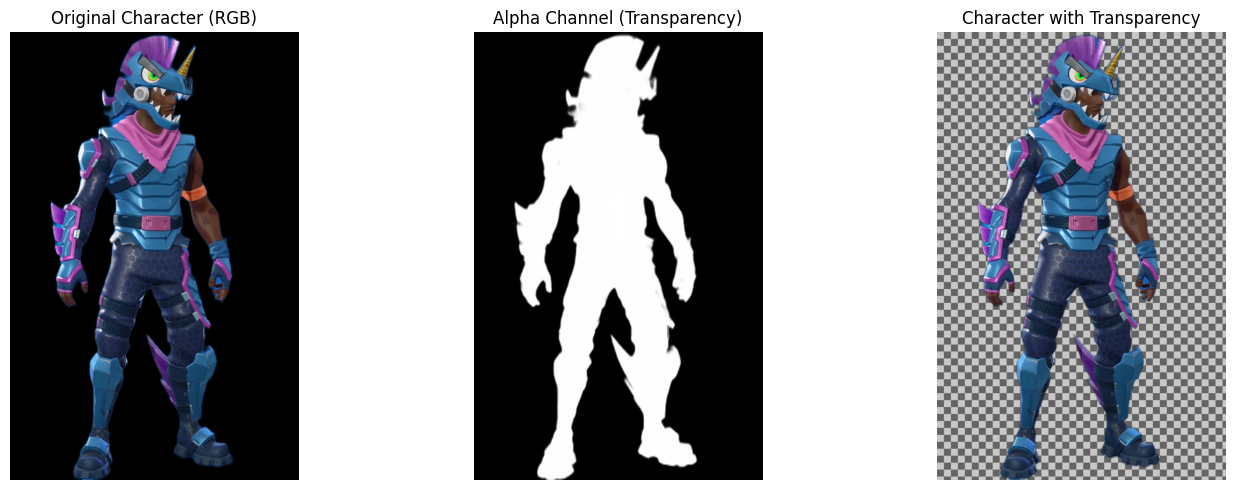

In [67]:
def debug_mask_creation(char_img, save_debug=False):
    """Debug function to visualize transparency for PNG files"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(char_img[:, :, :3])  # Show RGB channels only
    axes[0].set_title('Original Character (RGB)')
    axes[0].axis('off')
    
    # Show alpha channel if available
    if char_img.shape[2] == 4:
        alpha_channel = char_img[:, :, 3]
        axes[1].imshow(alpha_channel, cmap='gray')
        axes[1].set_title('Alpha Channel (Transparency)')
        axes[1].axis('off')
        
        # Show character with transparency on checkerboard
        h, w = char_img.shape[:2]
        checkerboard = np.zeros((h, w, 3), dtype=np.uint8)
        square_size = 20
        for i in range(0, h, square_size):
            for j in range(0, w, square_size):
                if (i // square_size + j // square_size) % 2 == 0:
                    checkerboard[i:i+square_size, j:j+square_size] = [200, 200, 200]
                else:
                    checkerboard[i:i+square_size, j:j+square_size] = [100, 100, 100]
        
        # Apply transparency
        alpha_mask = alpha_channel.astype(np.float32) / 255.0
        alpha_3d = np.stack([alpha_mask] * 3, axis=2)
        char_rgb = char_img[:, :, :3]
        result = (1 - alpha_3d) * checkerboard + alpha_3d * char_rgb
        
        axes[2].imshow(result.astype(np.uint8))
        axes[2].set_title('Character with Transparency')
        axes[2].axis('off')
    else:
        axes[1].text(0.5, 0.5, 'No Alpha Channel\n(RGB image)', 
                    ha='center', va='center', transform=axes[1].transAxes, fontsize=14)
        axes[1].axis('off')
        
        axes[2].imshow(char_img)
        axes[2].set_title('Character (No Transparency)')
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    if char_img.shape[2] == 4:
        return char_img[:, :, 3]  # Return alpha channel
    else:
        return None

# Test mask creation with a sample character (if available)
if character_poses:
    sample_char = list(character_poses.keys())[0]
    sample_pose = character_poses[sample_char][0]
    
    try:
        # Load with alpha channel preserved for transparent PNGs
        test_img = cv2.imread(sample_pose, cv2.IMREAD_UNCHANGED)
        if test_img.shape[2] == 4:  # RGBA
            test_img = cv2.cvtColor(test_img, cv2.COLOR_BGRA2RGBA)
        else:  # RGB
            test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        print(f"Testing mask creation with: {sample_char}")
        print(f"Image shape: {test_img.shape} ({'RGBA' if test_img.shape[2] == 4 else 'RGB'})")
        debug_mask_creation(test_img)
    except Exception as e:
        print(f"Could not load test image: {e}")

In [68]:
# Main execution loop
print(f"Starting data augmentation process...")
print(f"Generating {NUM_ITERATIONS} augmented images...")
print("=" * 50)

successful_generations = 0
failed_generations = 0
all_annotations = []

for i in range(NUM_ITERATIONS):
    success, annotation_data = generate_augmented_image(i + 1)
    
    if success:
        successful_generations += 1
        all_annotations.append(annotation_data)
    else:
        failed_generations += 1
    
    # Progress update
    if (i + 1) % 10 == 0:
        print(f"Progress: {i + 1}/{NUM_ITERATIONS} ({(i + 1)/NUM_ITERATIONS*100:.1f}%)")
        print(f"Successful: {successful_generations}, Failed: {failed_generations}")
        print("-" * 30)

print("=" * 50)
print(f"Data augmentation complete!")
print(f"Total successful generations: {successful_generations}")
print(f"Total failed generations: {failed_generations}")
print(f"Success rate: {successful_generations/(successful_generations+failed_generations)*100:.1f}%")

# Save master annotation file
master_annotation_path = os.path.join(OUTPUT_DIR, "master_annotations.json")
with open(master_annotation_path, 'w') as f:
    json.dump({
        'total_images': successful_generations,
        'num_classes': 1,  # Single class: enemy
        'classes': ["enemy"],
        'config': {
            'scenes_dir': SCENES_DIR,
            'characters_dir': CHARACTERS_DIR,
            'num_iterations': NUM_ITERATIONS,
            'lighting_adjustment': ENABLE_LIGHTING_ADJUSTMENT,
            'lighting_strength': LIGHTING_STRENGTH if ENABLE_LIGHTING_ADJUSTMENT else 0,
            'single_class': True,
            'class_name': 'enemy'
        },
        'annotations': all_annotations
    }, f, indent=2)

print(f"Master annotations saved: {master_annotation_path}")
print(f"Individual JSON annotations saved in: {ANNOTATIONS_DIR}")
print(f"YOLO format labels saved in: {YOLO_LABELS_DIR}")
print(f"Class names saved in: {class_names_path}")
print(f"Augmented images saved in: {OUTPUT_DIR}")

# Create dataset.yaml file for YOLO training
dataset_yaml_path = os.path.join(OUTPUT_DIR, "dataset.yaml")
with open(dataset_yaml_path, 'w') as f:
    f.write(f"path: {os.path.abspath(OUTPUT_DIR)}\n")
    f.write(f"train: .\n")  # All images in the same directory for now
    f.write(f"val: .\n")   # You can split this later
    f.write(f"\n")
    f.write(f"nc: 1\n")  # Only 1 class: enemy
    f.write(f"names:\n")
    f.write(f"  0: enemy\n")

print(f"YOLO dataset config saved: {dataset_yaml_path}")

Starting data augmentation process...
Generating 100 augmented images...
Iteration 1: Placing 1 characters on scene
    Using PNG alpha channel, alpha range: 0.000 to 1.000
  - Placed 291 at (1471, 0) size: 198x302 distance: 0.27
  - Saved image: augmented_data/1.jpg
  - Saved JSON: augmented_data/annotations/1.json
  - Saved YOLO: augmented_data/labels/1.txt
Iteration 2: Placing 4 characters on scene
    Using PNG alpha channel, alpha range: 0.000 to 1.000
  - Placed 17907 at (247, 60) size: 193x290 distance: 0.14
    Using PNG alpha channel, alpha range: 0.000 to 1.000
  - Placed 359 at (164, 159) size: 68x105 distance: 0.68
    Using PNG alpha channel, alpha range: 0.000 to 1.000
  - Placed 665 at (47, 176) size: 68x105 distance: 0.61
    Using PNG alpha channel, alpha range: 0.000 to 1.000
  - Placed 10007 at (8, 180) size: 67x105 distance: 0.45
  - Saved image: augmented_data/2.jpg
  - Saved JSON: augmented_data/annotations/2.json
  - Saved YOLO: augmented_data/labels/2.txt
    Us

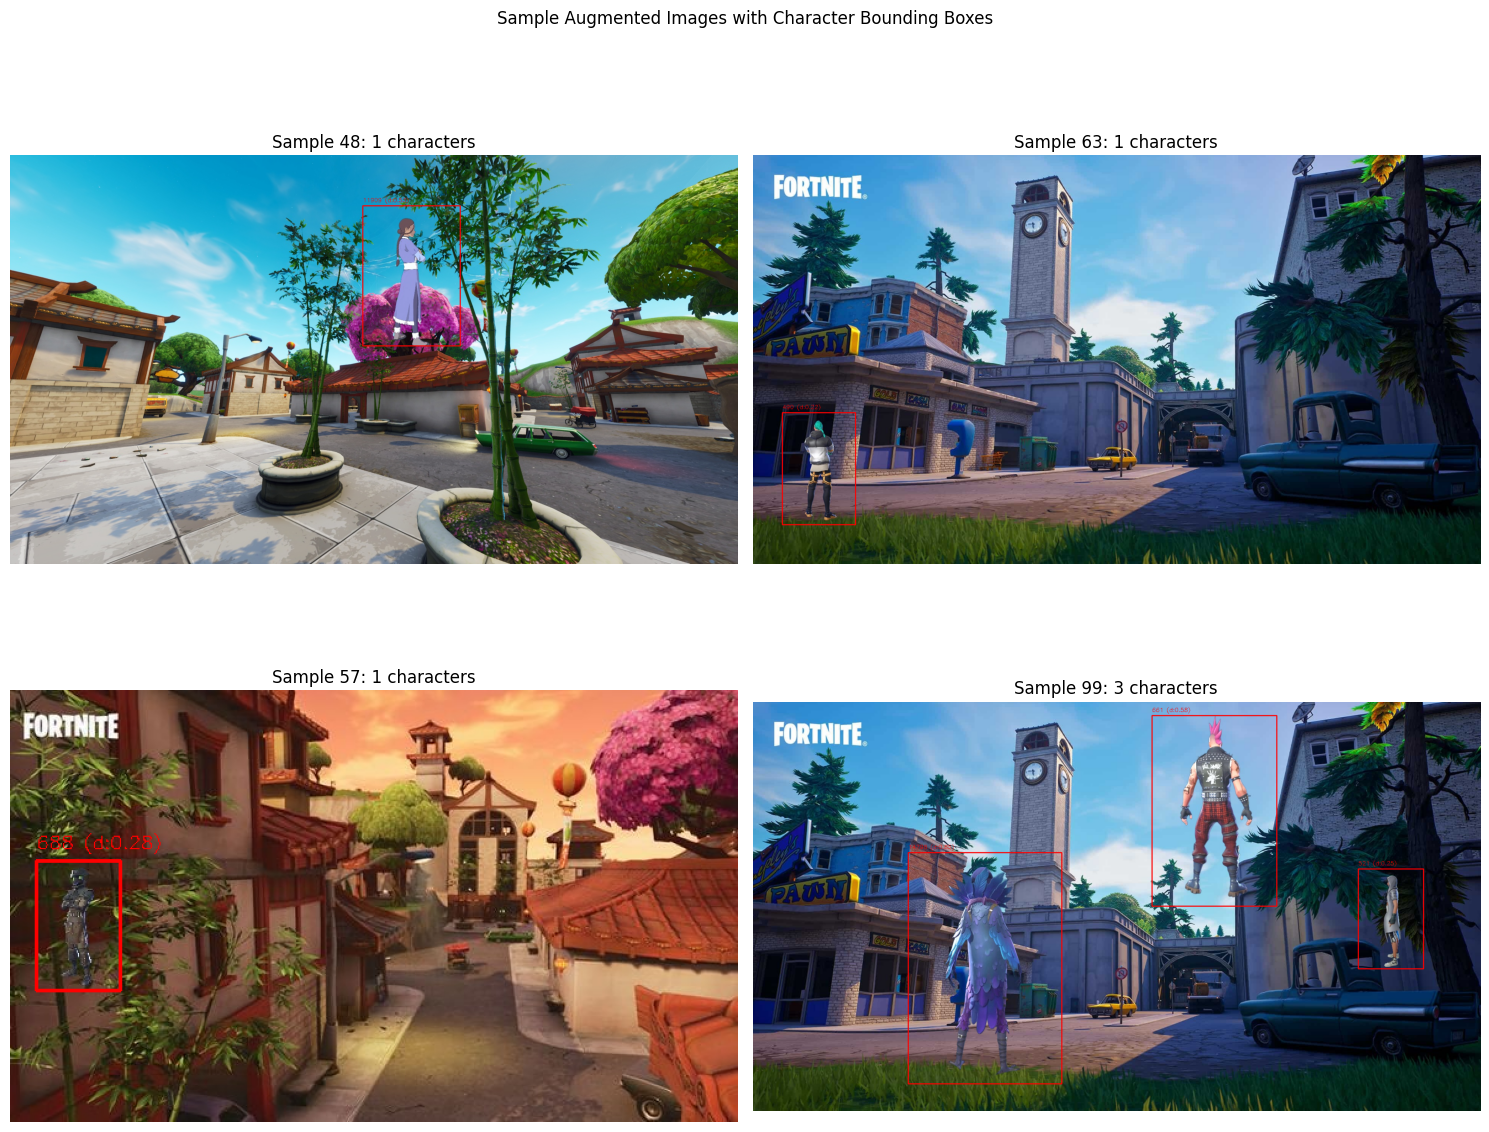

In [69]:
def visualize_sample_results(num_samples=4):
    """Visualize a few sample results"""
    if successful_generations == 0:
        print("No successful generations to visualize!")
        return
    
    # Get random sample of generated images
    sample_indices = random.sample(range(min(successful_generations, len(all_annotations))), 
                                 min(num_samples, successful_generations))
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, idx in enumerate(sample_indices):
        if i >= len(axes):
            break
            
        annotation = all_annotations[idx]
        img_path = os.path.join(OUTPUT_DIR, annotation['image_name'])
        
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Draw bounding boxes for characters
            for char_info in annotation['characters']:
                bbox = char_info['bbox']
                x, y, w, h = bbox['x'], bbox['y'], bbox['width'], bbox['height']
                
                # Draw rectangle
                cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
                
                # Add label
                label = f"{char_info['character_name'][:8]} (d:{bbox['distance_factor']:.2f})"
                cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                           0.5, (255, 0, 0), 1)
            
            axes[i].imshow(img)
            axes[i].set_title(f"Sample {idx + 1}: {len(annotation['characters'])} characters")
            axes[i].axis('off')
            
        except Exception as e:
            print(f"Error visualizing {img_path}: {e}")
            axes[i].text(0.5, 0.5, f"Error loading\n{annotation['image_name']}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(sample_indices), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle("Sample Augmented Images with Character Bounding Boxes", y=1.02)
    plt.show()

# Visualize results
if successful_generations > 0:
    visualize_sample_results()

DATA GENERATION STATISTICS
Character count distribution:
  1 character(s): 28 images (28.0%)
  2 character(s): 22 images (22.0%)
  3 character(s): 23 images (23.0%)
  4 character(s): 27 images (27.0%)

Total characters placed: 249
Average characters per image: 2.49

Top 10 most used characters:
  4971: 3 times (1.2%)
  260: 3 times (1.2%)
  133: 3 times (1.2%)
  17907: 2 times (0.8%)
  359: 2 times (0.8%)
  499: 2 times (0.8%)
  381: 2 times (0.8%)
  109: 2 times (0.8%)
  554: 2 times (0.8%)
  365: 2 times (0.8%)

Distance simulation:
  Average distance factor: 0.518
  Min distance factor: 0.109
  Max distance factor: 0.989


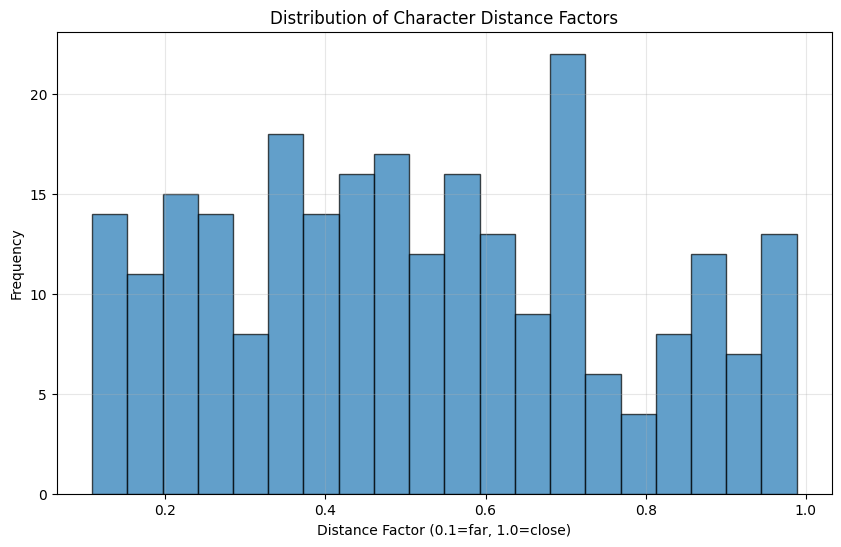

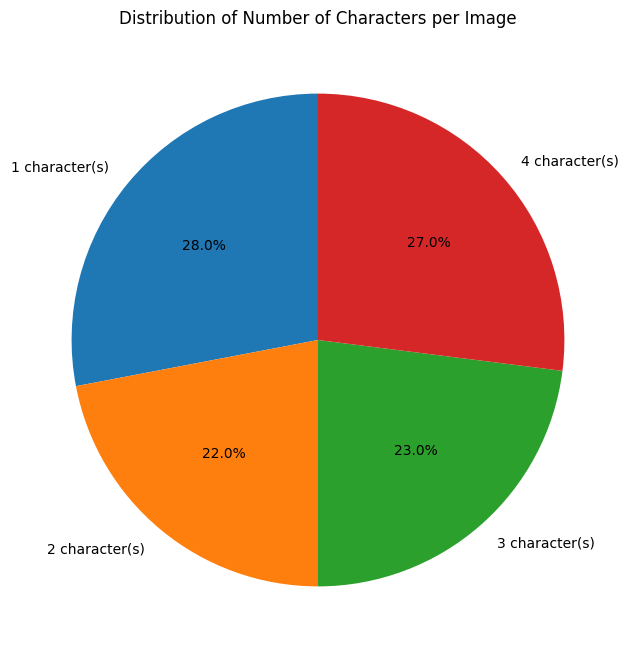

In [70]:
def analyze_generation_statistics():
    """Analyze and display statistics about the generated data"""
    if not all_annotations:
        print("No data to analyze!")
        return
    
    print("=" * 50)
    print("DATA GENERATION STATISTICS")
    print("=" * 50)
    
    # Character count distribution
    char_counts = [len(ann['characters']) for ann in all_annotations]
    print(f"Character count distribution:")
    for i in range(1, 5):
        count = char_counts.count(i)
        percentage = (count / len(char_counts)) * 100
        print(f"  {i} character(s): {count} images ({percentage:.1f}%)")
    
    # Most used characters
    char_usage = {}
    total_chars_placed = 0
    distance_factors = []
    
    for ann in all_annotations:
        for char_info in ann['characters']:
            char_name = char_info['character_name']
            char_usage[char_name] = char_usage.get(char_name, 0) + 1
            total_chars_placed += 1
            distance_factors.append(char_info['bbox']['distance_factor'])
    
    print(f"\nTotal characters placed: {total_chars_placed}")
    print(f"Average characters per image: {total_chars_placed/len(all_annotations):.2f}")
    
    # Top 10 most used characters
    top_chars = sorted(char_usage.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nTop 10 most used characters:")
    for char, count in top_chars:
        percentage = (count / total_chars_placed) * 100
        print(f"  {char}: {count} times ({percentage:.1f}%)")
    
    # Distance distribution
    avg_distance = np.mean(distance_factors)
    print(f"\nDistance simulation:")
    print(f"  Average distance factor: {avg_distance:.3f}")
    print(f"  Min distance factor: {min(distance_factors):.3f}")
    print(f"  Max distance factor: {max(distance_factors):.3f}")
    
    # Distance distribution histogram
    plt.figure(figsize=(10, 6))
    plt.hist(distance_factors, bins=20, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Character Distance Factors')
    plt.xlabel('Distance Factor (0.1=far, 1.0=close)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Character count pie chart
    plt.figure(figsize=(8, 8))
    char_count_labels = [f'{i} character(s)' for i in range(1, 5)]
    char_count_values = [char_counts.count(i) for i in range(1, 5)]
    plt.pie(char_count_values, labels=char_count_labels, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Number of Characters per Image')
    plt.show()

# Run analysis
if successful_generations > 0:
    analyze_generation_statistics()

## Summary

This notebook has successfully generated synthetic training data by:

1. **Scene Selection**: Randomly selecting background scenes from the `scenes` directory
2. **Character Placement**: Placing 1-4 randomly selected characters per scene
3. **Realistic Sizing**: Sizing characters based on simulated distance from player (gaming perspective)
4. **Lighting Adjustment**: Using computer vision techniques to match character lighting to surrounding environment
5. **Full Coverage**: Ensuring all characters are placed fully within image boundaries

## Output Structure

```
augmented_data/
├── augmented_000001.jpg          # Generated images
├── augmented_000002.jpg
├── ...
├── master_annotations.json       # Combined annotation data
└── annotations/
    ├── augmented_000001.json     # Individual annotations
    ├── augmented_000002.json
    └── ...
```

## Key Features

- **Lighting Adaptation**: Uses LAB color space for realistic lighting adjustment
- **Distance Simulation**: Characters sized appropriately for gaming scenarios
- **Comprehensive Annotations**: Bounding boxes, character info, and distance factors
- **Quality Control**: Error handling and success/failure tracking

## Usage

1. Adjust `NUM_ITERATIONS` variable to control output volume
2. Ensure `scenes` and `character_frames_no_bg` directories exist
3. Run all cells to generate augmented dataset
4. Use generated images and annotations for model training

The generated data is ready for use in computer vision models for aim assist systems!